In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

In [4]:
train_set = datasets.MNIST('./data/train', download=True, train=True, transform=transform)
val_set = datasets.MNIST('./data/val', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

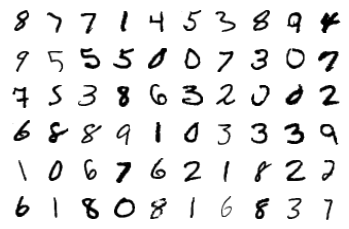

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

In [8]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("Training Time =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6344971701121533
Epoch 1 - Training loss: 0.28054702966642786
Epoch 2 - Training loss: 0.2162863539138646
Epoch 3 - Training loss: 0.174959759507924
Epoch 4 - Training loss: 0.14644606011723088
Epoch 5 - Training loss: 0.12487812017573159
Epoch 6 - Training loss: 0.10996927985591866
Epoch 7 - Training loss: 0.09713006979013399
Epoch 8 - Training loss: 0.08824586033273035
Epoch 9 - Training loss: 0.07840678657490466
Epoch 10 - Training loss: 0.07329524236508826
Epoch 11 - Training loss: 0.06690983984645194
Epoch 12 - Training loss: 0.06065531661148185
Epoch 13 - Training loss: 0.05718693777080824
Epoch 14 - Training loss: 0.05364153411627602
Training Time = 5.675636927286784


In [9]:
correct_count, all_count = 0, 0
for images, labels in val_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
print("Accuracy =", (correct_count / all_count))

Accuracy = 0.9736


In [14]:
torch.save(model, './model.pt')
traced_script_module = torch.jit.trace(model, images[0].view(1, 784))
traced_script_module.save("./traced_model.pt")